# Colab

In [1]:
# Montamos la unidad de Google Drive.
from google.colab import drive

ROOT = "/content/drive"     # Lugar default para montar la unidad.
print(ROOT)                 # Imprimimos la ruta default.

drive.mount(ROOT)           # Montamos la unidad de Drive en /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [2]:
# Seleccionamos la ruta de trabajo en Drive.
%cd drive/MyDrive/Colab Notebooks/TP_Ind4

/content/drive/MyDrive/Colab Notebooks/TP_Ind4


# Paquetes

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Importamos el set de entrenamiento.
train = pd.read_csv("data/Train.csv", index_col=0)

In [ ]:
train.shape

(33908, 35)

In [ ]:
# Separamos entre variables explicativas y respuesta.
X_train = train.drop('Subscription', axis = 1)
y_train = train['Subscription']

## Optimization Function

Generamos la función de profit para optimizar los hiperparámetros.

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer

def profit_mean(y_true, y_pred):
  mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
  n = len(y_true)
  prof = 250 * mat[1,1] - 50 * mat[0,1] - 25 * mat[1,0]
  return prof/n

In [ ]:
profit_mean_score = make_scorer(profit_mean, greater_is_better=True)

## A tener en cuenta
Cuando tuneamos un modelo:
* **Siempre** incluir todos sus **hiperparámetros en el grid**, aunque sea con el valor default. Esto hace que el dataframe que generamos con los resultados tenga toda la información y, si después queremos tunear un hiperparámetro que no habíamos tuneado, **no se agrega una nueva columna**.
* **Siempre** incluir el *train score* para ver si tenemos overfitting, comparando con el resultado de test.

In [ ]:
# Grid de valores de hiperparámetros.
tree_grid = {'criterion': ['gini'],
            'splitter': ['best'],
            'max_depth': [9, 11, 13, 15, 20, None],
            'max_features': [None, 0.7],
            'ccp_alpha': [0],#, 0.001, 0.01, 0.1], 
            'max_leaf_nodes':[None, 10], #20, 40], 
            'min_samples_leaf':[1],#,  #200, 400],
            'class_weight':[{1: w} for w in [1, 3, 6]]}#, 9, 10]]}

In [ ]:
# Hiperparámetros fijos del modelo entrenado.
tree = DecisionTreeClassifier(random_state = 43)

In [ ]:
time_start = time.time()

# Grid Search
tree_cv = GridSearchCV(tree, tree_grid, cv = 5, scoring=profit_mean_score, verbose=10, n_jobs=-1, return_train_score=True, refit=True)

# Randomized Search
#svm_cv = RandomizedSearchCV(svm, svm_grid, n_iter = 500, cv = 10, scoring='accuracy', verbose=10, n_jobs=-1, random_state=354)

tree_cv.fit(X_train, y_train.values.ravel())

# Generamos y mostramos un Dataframe con los resultados del GridSearch
tree_cv_results = pd.DataFrame(tree_cv.cv_results_)
print(tree_cv_results.head(10))

# Generamos un csv con los resultados para el modelo.
#tree_cv_results.to_csv('model tunning/Tree/Tree_CVResults.csv')
#tree_cv_results.to_csv('model tunning/Tree/Tree_CVResults.csv', mode='a', header=False)

# Imprimimos el tiempo total de duración de Cross-Validation.
time_finish = time.time()
print(f'Duración {round(time_finish - time_start, 5)} segundos')
print(f'Duración {round((time_finish - time_start)/60, 5)} minutos')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.199197      0.005863  ...         11.034637         0.218510
1       0.127130      0.008799  ...          7.588734         0.377035
2       0.162679      0.012263  ...         10.662123         0.488140
3       0.097198      0.008383  ...          7.556293         0.280456
4       0.234960      0.006873  ...         13.712472         0.396988
5       0.118907      0.006660  ...          7.588734         0.377035
6       0.178592      0.012595  ...         12.993621         0.665191
7       0.092857      0.005166  ...          7.556293         0.280456
8       0.271869      0.015503  ...         16.853330         0.576790
9       0.119430      0.007219  ...          7.588734         0.377035

[10 rows x 28 columns]
Duración 38.11021 segundos
Duración 0.63517 minutos


In [ ]:
tree_cv_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
50,0.153986,0.003038,0.008974,0.000792,0,{1: 6},gini,9,0.7,None,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",13.926570,13.476850,13.425243,12.468662,14.507447,13.560955,0.670540,1,17.100752,16.923800,17.056514,16.986766,16.872489,16.988064,0.083514
48,0.199162,0.008287,0.008093,0.000158,0,{1: 6},gini,9,None,None,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",13.679593,13.244618,13.233559,13.147028,14.319422,13.524844,0.438502,2,17.219642,17.276782,17.020571,17.135142,17.052199,17.140867,0.096999
49,0.111635,0.000552,0.009586,0.002852,0,{1: 6},gini,9,None,10,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",12.868623,12.503686,13.539516,13.430910,14.135083,13.295564,0.564265,3,13.558026,13.758018,13.486139,13.728020,13.341873,13.574415,0.154558
69,0.114968,0.005268,0.007960,0.000165,0,{1: 6},gini,None,None,10,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",12.868623,12.503686,13.539516,13.430910,14.135083,13.295564,0.564265,3,13.558026,13.758018,13.486139,13.728020,13.341873,13.574415,0.154558
65,0.110287,0.001298,0.007995,0.000387,0,{1: 6},gini,20,None,10,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",12.868623,12.503686,13.539516,13.430910,14.135083,13.295564,0.564265,3,13.558026,13.758018,13.486139,13.728020,13.341873,13.574415,0.154558


In [ ]:
hyperparams = ['param_ccp_alpha', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_min_samples_leaf', 'param_splitter']
for hyperparam in hyperparams:
  print(tree_cv_results.groupby([hyperparam]).agg({'mean_test_score':'mean'}))

                 mean_test_score
param_ccp_alpha                 
0.000                   0.455055
0.001                   0.454779
0.010                   0.343906
0.100                   0.058716
                 mean_test_score
param_criterion                 
gini                    0.328114
                 mean_test_score
param_max_depth                 
9                       0.328412
11                      0.328672
13                      0.328434
15                      0.328174
20                      0.327770
                    mean_test_score
param_max_features                 
0.7                        0.325707
                      mean_test_score
param_max_leaf_nodes                 
10                           0.325050
20                           0.331388
40                           0.332492
                        mean_test_score
param_min_samples_leaf                 
1                              0.338010
200                            0.328215
400           

# Results

In [10]:
# Importamos los resultados.
results = pd.read_csv('model tunning/Tree/Tree_CVResults.csv', index_col = 0)

In [11]:
results.shape

(1536, 28)

In [7]:
# Seleccionamos solamente las columnas de los hiperparámetros y resultados de train y CV.
features = ['param_ccp_alpha', 
            'param_criterion', 
            'param_max_depth', 
            'param_max_features', 
            'param_max_leaf_nodes', 
            'param_min_samples_leaf', 
            'param_splitter',
            'mean_test_score', 
            'mean_train_score']
# Reseteamos el índice del df.
results = results[features].reset_index(drop = True)
# Completamos los NAs con 'None'.
results.fillna(value = 'None', inplace = True)

In [12]:
results.sort_values('mean_test_score', ascending = False).drop_duplicates().head(25)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
139,0.159262,0.004961,0.007741,0.000060,0.000,{1: 6},gini,NaN,NaN,40.0,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",99950.0,97425.0,100700.0,99700.0,107625.0,101080.0,3450.268106,1,413350.0,426025.0,422725.0,421450.0,423200.0,421350.0,4270.333711
123,0.156609,0.003341,0.008021,0.000340,0.000,{1: 6},gini,15.0,NaN,40.0,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",99950.0,97425.0,100700.0,99700.0,107625.0,101080.0,3450.268106,1,413350.0,426025.0,422725.0,421450.0,423200.0,421350.0,4270.333711
115,0.168914,0.005603,0.008264,0.000164,0.000,{1: 6},gini,13.0,NaN,40.0,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",99950.0,97425.0,100700.0,99700.0,107625.0,101080.0,3450.268106,1,413350.0,426025.0,422725.0,421450.0,423200.0,421350.0,4270.333711
131,0.161562,0.006661,0.008271,0.000954,0.000,{1: 6},gini,20.0,NaN,40.0,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",99950.0,97425.0,100700.0,99700.0,107625.0,101080.0,3450.268106,1,413350.0,426025.0,422725.0,421450.0,423200.0,421350.0,4270.333711
107,0.157746,0.008536,0.008134,0.000367,0.000,{1: 6},gini,11.0,NaN,40.0,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",99950.0,97425.0,100700.0,100225.0,106800.0,101020.0,3105.213358,5,413350.0,426025.0,422725.0,418350.0,415425.0,419175.0,4651.854469
99,0.158345,0.004252,0.009382,0.001237,0.000,{1: 6},gini,9.0,NaN,40.0,1,best,"{'ccp_alpha': 0, 'class_weight': {1: 6}, 'crit...",99575.0,97400.0,98250.0,98225.0,107525.0,100195.0,3730.663480,6,414900.0,421025.0,416775.0,410500.0,411600.0,414960.0,3775.268202
288,0.196718,0.007473,0.007948,0.000252,0.001,{1: 6},gini,9.0,NaN,NaN,1,best,"{'ccp_alpha': 0.001, 'class_weight': {1: 6}, '...",98475.0,95775.0,98725.0,96225.0,107175.0,99275.0,4120.800893,7,406125.0,413550.0,407350.0,404550.0,403725.0,407060.0,3478.526987
291,0.153587,0.003979,0.008419,0.000548,0.001,{1: 6},gini,9.0,NaN,40.0,1,best,"{'ccp_alpha': 0.001, 'class_weight': {1: 6}, '...",98475.0,95775.0,98725.0,96225.0,107175.0,99275.0,4120.800893,7,406125.0,413550.0,407350.0,404550.0,403725.0,407060.0,3478.526987
296,0.233347,0.015370,0.008564,0.000623,0.001,{1: 6},gini,11.0,NaN,NaN,1,best,"{'ccp_alpha': 0.001, 'class_weight': {1: 6}, '...",98475.0,95775.0,98725.0,96225.0,107175.0,99275.0,4120.800893,7,406125.0,413550.0,407350.0,404550.0,403725.0,407060.0,3478.526987
299,0.161256,0.011592,0.008328,0.000509,0.001,{1: 6},gini,11.0,NaN,40.0,1,best,"{'ccp_alpha': 0.001, 'class_weight': {1: 6}, '...",98475.0,95775.0,98725.0,96225.0,107175.0,99275.0,4120.800893,7,406125.0,413550.0,407350.0,404550.0,403725.0,407060.0,3478.526987


In [ ]:
hyperparams = ['param_ccp_alpha', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_min_samples_leaf', 'param_splitter']
for hyperparam in hyperparams:
  print(results.groupby([hyperparam]).agg({'mean_test_score':'mean'}))

                 mean_test_score
param_ccp_alpha                 
0.000                   0.900994
0.001                   0.902618
0.010                   0.883227
0.100                   0.500000
                 mean_test_score
param_criterion                 
entropy                 0.800848
gini                    0.792571
                 mean_test_score
param_max_depth                 
5.0                     0.798218
7.0                     0.797048
9.0                     0.797221
11.0                    0.796956
13.0                    0.796897
15.0                    0.796909
20.0                    0.796274
25.0                    0.796003
30.0                    0.795878
None                    0.795691
                    mean_test_score
param_max_features                 
0.7                        0.793300
None                       0.800119
                      mean_test_score
param_max_leaf_nodes                 
10.0                         0.785959
20.0            

## Best Model

In [ ]:
%cd model tunning/Tree

/content/drive/My Drive/Colab Notebooks/TP_Ind4/model tunning/Tree


In [ ]:
from ModelCompare import modelCompareClass

In [ ]:
%cd ..
%cd ..
%pwd

/content/drive/My Drive/Colab Notebooks/TP_Ind4/model tunning
/content/drive/My Drive/Colab Notebooks/TP_Ind4


'/content/drive/My Drive/Colab Notebooks/TP_Ind4'

In [ ]:
validation = pd.read_csv("data/Validation.csv", index_col=0)
X_val = validation.drop("Subscription", axis = 1)
y_val = validation["Subscription"]

In [ ]:
Results = modelCompareClass(predictions="Validation")

------------Tree------------

---------Train Metrics-----------
Accuracy = 0.8408340214698596
Sensibility = 0.829342072094782
Specificity = 0.8423566347149394
AUC = 0.9139903342551333

Confusion Matrix
[[25221  4720]
 [  677  3290]]
-----------------------------------


-----------Validation Metrics-----------
Accuracy = 0.8269332861440453
Sensibility = 0.7685325264750378
Specificity = 0.8346693386773547
AUC = 0.8595284366008871

Confusion Matrix
[[4165  825]
 [ 153  508]]


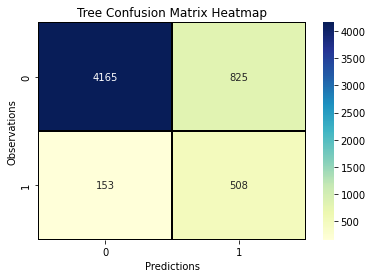

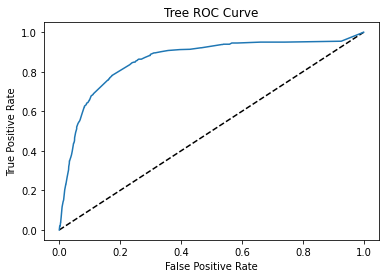

Tree Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4990
           1       0.38      0.77      0.51       661

    accuracy                           0.83      5651
   macro avg       0.67      0.80      0.70      5651
weighted avg       0.90      0.83      0.85      5651



In [ ]:
Results.modelReportClass("Tree", 
                         tree_cv.best_estimator_, 
                         X_train, 
                         y_train,
                         X_val,
                         y_val, classReport = True)

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [ ]:
def profit(y_true, y_pred):
  mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
  prof = 250 * mat[1,1] - 50 * mat[0,1] - 25 * mat[1,0]
  return prof

In [ ]:
confusion_matrix(y_val,
                 tree_cv.best_estimator_.predict(X_val))[0,1]

825

In [ ]:
tree_cv.best_estimator_.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0, class_weight={1: 6}, max_depth=13,
                       max_leaf_nodes=40, random_state=43)>

In [ ]:
profit(y_val, tree_cv.best_estimator_.predict(X_val))#/len(y_val)

81925

In [ ]:
profit(y_val, tree_cv.best_estimator_.predict(X_val))

85300

In [ ]:
proba_cut = np.arange(0, 1, 0.01)

for proba in proba_cut:

  y_pred_proba = tree_cv.best_estimator_.predict_proba(X_val)[:,1]
  
  y_pred = pd.Series(y_pred_proba).apply(lambda x: 1 if x > proba else 0)

  profit_value = profit(y_true = y_val, y_pred = y_pred)

  print(f'Proba: {proba} -- Profit: {profit_value}')

Proba: 0.0 -- Profit: -74100
Proba: 0.01 -- Profit: -28525
Proba: 0.02 -- Profit: -10525
Proba: 0.03 -- Profit: -10525
Proba: 0.04 -- Profit: -8875
Proba: 0.05 -- Profit: 9350
Proba: 0.06 -- Profit: 14700
Proba: 0.07 -- Profit: 19700
Proba: 0.08 -- Profit: 19700
Proba: 0.09 -- Profit: 20025
Proba: 0.1 -- Profit: 20675
Proba: 0.11 -- Profit: 34500
Proba: 0.12 -- Profit: 34500
Proba: 0.13 -- Profit: 50500
Proba: 0.14 -- Profit: 50500
Proba: 0.15 -- Profit: 50500
Proba: 0.16 -- Profit: 63875
Proba: 0.17 -- Profit: 67775
Proba: 0.18 -- Profit: 67775
Proba: 0.19 -- Profit: 67775
Proba: 0.2 -- Profit: 67775
Proba: 0.21 -- Profit: 67775
Proba: 0.22 -- Profit: 69475
Proba: 0.23 -- Profit: 69475
Proba: 0.24 -- Profit: 69400
Proba: 0.25 -- Profit: 69400
Proba: 0.26 -- Profit: 69400
Proba: 0.27 -- Profit: 69900
Proba: 0.28 -- Profit: 71800
Proba: 0.29 -- Profit: 71800
Proba: 0.3 -- Profit: 73700
Proba: 0.31 -- Profit: 75400
Proba: 0.32 -- Profit: 75450
Proba: 0.33 -- Profit: 75450
Proba: 0.34 -- 